## Import Necessaries

In [61]:
import json
import pandas as pd
import numpy as np
import shutil
import os
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import re

import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from glob import glob
from PIL import Image
import pickle

from tqdm import tqdm
import collections
import random

from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import backend as k
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image


In [8]:
'''
#Read json file
with open('/home/shankar/Desktop/YELP/Food/IPYNB/preproccaption.json') as data_file:
    data=json.load(data_file)
#Convert to DataFrame
df=DataFrame(data['photojson'])
'''
df_caption=pd.read_json('/home/shankar/Desktop/YELP/Food/IPYNB/preproccaption.json') #before
#df_caption=pd.read_json('/home/shankar/Desktop/YELP/Food/IPYNB/newcorrectedcaption.json')



In [9]:
df_caption

,photo_id,caption,label,preproc
1,002gqWfVal1D2DT6oA-bVQ,12oz. Boneless Ribeye | Grilled to perfection ...,food,oz boneless ribeye grilled perfection choice s...
2,002GtTSYyQ4swIZyEnfF5A,"The Most Yummy Tarts: Chantilly, Guava, Salted...",food,yummy tarts chantilly guava salted caramel cof...
5,004a5VhdS6w9PaH0QmlX9g,Shrimp,food,shrimp
7,005Pl2rEa-y9OfU8Nbcy4Q,"Shrimp, mussels, crawfish, crab claws, potatoe...",food,shrimp mussel crawfish crab claw potato corn
9,007FeerwcQQRx7ck_xA0QA,Surf and turf with 1.5lb lobster and 7oz Filet...,food,surf turf lb lobster oz filet mignon delicious...
...,...,...,...,...
199980,ZZ_WrOChc6eB3yPgWhbuWA,Fresh food everyday,food,fresh food everyday
199983,zZWWip7yNQIlLaTbYJC_IA,creamed mussel,food,cream mussel
199984,zzXARW5UJhgRDZ20lb1CPg,Arancini Classico,food,arancini classico
199988,zZykbO6ggfCpR5_Z8F5OHw,Khao soi poutine ($9.95),food,khao soi poutine


In [10]:
'''
#caption and nocaption
df_caption = df[df['caption']!=""]
df_nocaption = df[df['caption']==""]

#Consider only food dataframe
df_caption = df_caption[df_caption['label']=="food"] 
'''

'\n#caption and nocaption\ndf_caption = df[df[\'caption\']!=""]\ndf_nocaption = df[df[\'caption\']==""]\n\n#Consider only food dataframe\ndf_caption = df_caption[df_caption[\'label\']=="food"] \n'

In [11]:
PATH="/home/shankar/Desktop/YELP/Food/DATA/"

In [12]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for ind in df_caption.index:
    caption = "<start> "+ df_caption['preproc'][ind]+" <end> " #before
    #caption = "<start> "+ df_caption['newcaption'][ind]+" <end> " #after
    image_path = PATH + 'zcapfood/' + '%012s.jpg' % (df_caption['photo_id'][ind])
    image_path_to_caption[image_path].append(caption)

In [13]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# All captioned images for training
train_image_paths = image_paths[:58397]
print(len(train_image_paths))

58397


In [14]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

<start> fried catfish <end> 


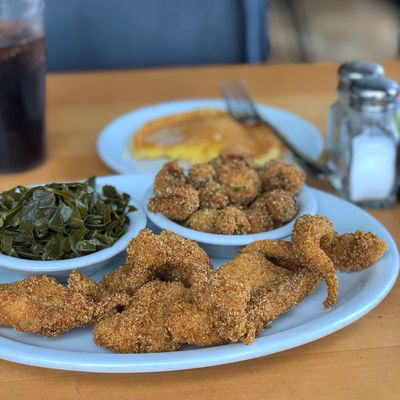

In [15]:
print(train_captions[0])
Image.open(img_name_vector[0])

### Preprocess the images using InceptionV3

In [16]:
#Preprocess the images using InceptionV3
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

### Initialize InceptionV3 and load the pretrained Imagenet weights

In [17]:
#Initialize InceptionV3 and load the pretrained Imagenet weights
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [13]:
#Caching the features extracted from InceptionV3

# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████| 3650/3650 [05:25<00:00, 11.20it/s]


In [18]:
#Preprocess and tokenize the captions

# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [19]:
# Choose the top 5000 words from the vocabulary
top_k = 6000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [20]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [21]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [22]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [23]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

### Split the data into training and testing

In [25]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [26]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(46717, 46717, 11680, 11680)

In [ ]:
#Create a tf.data dataset for training

In [28]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [29]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [30]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Model

In [32]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### CNN Image Encoder

In [33]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### RNN Text Decoder

In [34]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [35]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

### Loss and Optimization

In [36]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [37]:
#Checkpoint

In [38]:
checkpoint_path = "./checkpoints/finaltrain"
#checkpoint_path = "./checkpoints/beforetrain"
#checkpoint_path = "./checkpoints/aftertrain"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [39]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

### Training

In [41]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [42]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [38]:
import time
EPOCHS = 50

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.5026
Epoch 1 Batch 100 Loss 1.1552
Epoch 1 Batch 200 Loss 1.1511
Epoch 1 Batch 300 Loss 0.9935
Epoch 1 Batch 400 Loss 1.0180
Epoch 1 Batch 500 Loss 1.3838
Epoch 1 Batch 600 Loss 1.0578
Epoch 1 Batch 700 Loss 1.0259
Epoch 1 Loss 1.070798
Time taken for 1 epoch 117.2869918346405 sec

Epoch 2 Batch 0 Loss 0.8757
Epoch 2 Batch 100 Loss 1.0159
Epoch 2 Batch 200 Loss 0.8381
Epoch 2 Batch 300 Loss 0.7566
Epoch 2 Batch 400 Loss 1.0317
Epoch 2 Batch 500 Loss 0.7097
Epoch 2 Batch 600 Loss 0.9533
Epoch 2 Batch 700 Loss 0.8291
Epoch 2 Loss 0.904356
Time taken for 1 epoch 81.69999384880066 sec

Epoch 3 Batch 0 Loss 0.9351
Epoch 3 Batch 100 Loss 0.8573
Epoch 3 Batch 200 Loss 0.7855
Epoch 3 Batch 300 Loss 0.7884
Epoch 3 Batch 400 Loss 0.9715
Epoch 3 Batch 500 Loss 0.8110
Epoch 3 Batch 600 Loss 0.9086
Epoch 3 Batch 700 Loss 0.8629
Epoch 3 Loss 0.825164
Time taken for 1 epoch 80.62904834747314 sec

Epoch 4 Batch 0 Loss 0.8319
Epoch 4 Batch 100 Loss 0.7524
Epoch 4 Batch 200 Loss 0

Epoch 27 Batch 300 Loss 0.0780
Epoch 27 Batch 400 Loss 0.1184
Epoch 27 Batch 500 Loss 0.1668
Epoch 27 Batch 600 Loss 0.1394
Epoch 27 Batch 700 Loss 0.1096
Epoch 27 Loss 0.134711
Time taken for 1 epoch 80.06557416915894 sec

Epoch 28 Batch 0 Loss 0.1811
Epoch 28 Batch 100 Loss 0.1151
Epoch 28 Batch 200 Loss 0.1212
Epoch 28 Batch 300 Loss 0.0914
Epoch 28 Batch 400 Loss 0.1301
Epoch 28 Batch 500 Loss 0.1494
Epoch 28 Batch 600 Loss 0.0883
Epoch 28 Batch 700 Loss 0.1211
Epoch 28 Loss 0.126440
Time taken for 1 epoch 79.79847264289856 sec

Epoch 29 Batch 0 Loss 0.1884
Epoch 29 Batch 100 Loss 0.1065
Epoch 29 Batch 200 Loss 0.0966
Epoch 29 Batch 300 Loss 0.1262
Epoch 29 Batch 400 Loss 0.1516
Epoch 29 Batch 500 Loss 0.1528
Epoch 29 Batch 600 Loss 0.1210
Epoch 29 Batch 700 Loss 0.1196
Epoch 29 Loss 0.120954
Time taken for 1 epoch 79.90915489196777 sec

Epoch 30 Batch 0 Loss 0.1433
Epoch 30 Batch 100 Loss 0.1351
Epoch 30 Batch 200 Loss 0.1482
Epoch 30 Batch 300 Loss 0.1196
Epoch 30 Batch 400 Loss 

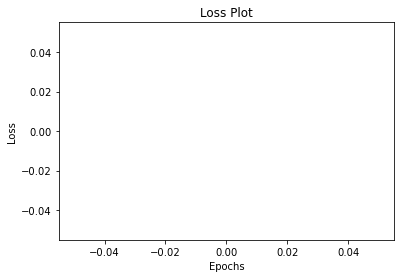

In [36]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [37]:
#Caption!

In [43]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [44]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

# Use trained Multi Label Classifier to Predict Label

In [65]:
#Multi label classifier
model = keras.models.load_model("/home/shankar/Desktop/YELP/Food/Multi/2ffocat/modelsorg/inceptionv3_multiclass_best.h5")

In [66]:
dft = pd.read_json(r'ffocatlabels.json')
label=dft['FoodName']
classes = np.array(label)

# Evaluation on randomly selected 30 validation images of YELP

In [161]:
# captions on the validation set random
rdf = pd.DataFrame() 

#Lists to create dataframe
r=[]
p=[]
l=[]
pc=[]
gc=[]
for a in range(30):
    rid = np.random.randint(0, len(img_name_val))
    print(img_name_val[rid])
    img = img_name_val[rid]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
    result, attention_plot = evaluate(img)

    img1 = image.load_img(img,target_size=(299,299,3))
    img1 = image.img_to_array(img1)
    img1 = img1/255
    classes = np.array(label)
    proba = model.predict(img1.reshape(1,299,299,3))
    top_3 = np.argsort(proba[0])[:-5:-1]
    label_result=classes[top_3[0]]
    
    r.append(real_caption)
    p.append(img[46:])
    l.append(label_result)
    pc.append(' '.join(result))
    gc.append(' '.join(result)+" " +label_result)

    print ('\nReal Caption:', real_caption)
    print ('Predicted Caption:', ' '.join(result))
    print ('Predicted Label:',label_result)
    print ('Generated Caption:', ' '.join(result)+" " +label_result)
    #plot_attention(img, result, attention_plot)
    '''
    print ('Real Caption:', real_caption)
    print ('Generated Caption:', ' '.join(result))
    plot_attention(image, result, attention_plot)
    '''
# dictionary of lists  
dict = {'Photo_id': p,'Actual Caption':r, 'Predicted Caption': pc, 'Predicted Label': l,'Generated Caption':gc}
rdf = pd.DataFrame(dict) 


/home/shankar/Desktop/YELP/Food/DATA/zcapfood/0yYWGY5H7IHuZWnsG5HRgQ.jpg

Real Caption: <start> <unk> edamame <end>
Predicted Caption: <unk> espresso <end>
Predicted Label: Fish nuggets
Generated Caption: <unk> espresso <end> Fish nuggets
/home/shankar/Desktop/YELP/Food/DATA/zcapfood/1LfTFrneMCAw0IHtCEt5yQ.jpg

Real Caption: <start> friday afternoon <unk> <end>
Predicted Caption: chef table doughnut <end>
Predicted Label: Carrots with bay leaves
Generated Caption: chef table doughnut <end> Carrots with bay leaves
/home/shankar/Desktop/YELP/Food/DATA/zcapfood/N9cVCgRsnG_yGbWU5Y9jVw.jpg

Real Caption: <start> party <end>
Predicted Caption: tres <end>
Predicted Label: Toasted bread with cheese
Generated Caption: tres <end> Toasted bread with cheese
/home/shankar/Desktop/YELP/Food/DATA/zcapfood/mGCbcc25e3eDBNWfEc1JGg.jpg

Real Caption: <start> kitchen ono platter <end>
Predicted Caption: sticky schnitzel platter <end>
Predicted Label: Mixed Cheeses
Generated Caption: sticky schnitzel platt

In [162]:
rdf

,Photo_id,Actual Caption,Predicted Caption,Predicted Label,Generated Caption
0,0yYWGY5H7IHuZWnsG5HRgQ.jpg,<start> <unk> edamame <end>,<unk> espresso <end>,Fish nuggets,<unk> espresso <end> Fish nuggets
1,1LfTFrneMCAw0IHtCEt5yQ.jpg,<start> friday afternoon <unk> <end>,chef table doughnut <end>,Carrots with bay leaves,chef table doughnut <end> Carrots with bay leaves
2,N9cVCgRsnG_yGbWU5Y9jVw.jpg,<start> party <end>,tres <end>,Toasted bread with cheese,tres <end> Toasted bread with cheese
3,mGCbcc25e3eDBNWfEc1JGg.jpg,<start> kitchen ono platter <end>,sticky schnitzel platter <end>,Mixed Cheeses,sticky schnitzel platter <end> Mixed Cheeses
4,fokpPmYtNTm3ttUTtkoFRg.jpg,<start> <unk> roll <end>,mango salad <end>,Lemon chicken strips,mango salad <end> Lemon chicken strips
5,4z_MgClP7fQtytI4Cg6t2g.jpg,<start> ass impossible <end>,butter <end>,Mushrooms soup,butter <end> Mushrooms soup
6,g0ZFHUe_UR1cT4BAOg1Kpg.jpg,<start> shrimp pad thai fior <unk> odd banana ...,shrimp two wrap character <unk> rudy banana <end>,Basmati rice with tikka masala chicken,shrimp two wrap character <unk> rudy banana <e...
7,IhvFILHnD8dbzDHZfhK7hw.jpg,<start> lunch combo caribbean nut chicken egg ...,octopus <end>,Chicken with curry,octopus <end> Chicken with curry
8,-1T41Fj-Tit55MbH3tm6YA.jpg,<start> cherry <unk> shish season shrimp award...,soul <end>,Sweet-and-sour onions,soul <end> Sweet-and-sour onions
9,gzWGqkcfhUXOkSOo0LioYQ.jpg,<start> margherita style cherry roasted barbac...,<unk> <end>,Baked trout fillet,<unk> <end> Baked trout fillet


In [163]:
#Save as json file
rdf.to_json(r'/home/shankar/Desktop/YELP/Food/IPYNB/Rev4/files/random_image_cap_eval_result.json')

In [164]:
#copy images
for photo_id in rdf.Photo_id:
    shutil.copy("/home/shankar/Desktop/YELP/Food/DATA/yelp_photos/photos/"+photo_id, "/home/shankar/Desktop/YELP/Food/IPYNB/Rev4/randomvalimages")        



# Evaluation on 10 Proper Captioned YELP images

In [126]:

#dft = pd.read_json('/home/shankar/Desktop/YELP/Food/IPYNB/Rev4/new_yelp_evaluation.json') #before
#dft = pd.read_json('/home/shankar/Desktop/YELP/Food/IPYNB/Rev4/eval_correct.json') #after & final
dft = pd.read_json('/home/shankar/Desktop/YELP/Food/IPYNB/Rev4/files/image_cap_eval.json') #image cap eval

In [127]:
dft

,Photo_id,Caption,label_predicted,Predicted Caption
0,EAG5C3SFX2RGVucam81dBw,"it a tuna poke with ramen, prime ribs, mac and...",Red wine braised beef with potatoes,lamb burn masala <end>
1,DmS_zjsO5l18AUy0NeC3Fw,it the vinegar based pork bbq dinner with bake...,Kebab,spicy chicken <end>
2,ea8xZSb3o0DY2OeDu8xtNg,"lamb shish kebab served with rice , fry and ga...",Baked mackerel fillet,beef cheek <end>
3,zzRPDXGXdm-kjIePvpyofQ,veg chicken wing and smoked tomato soup,Fish nuggets,katsu soup tre tamale huitlacoche crab <unk> <...
4,zzQga0hz996HjtyoPJlgAA,"nugget with tomato sauce, fish",Fish nuggets,sammy rib <end>
5,ZwtoYdGFZvazWnI4U7Y3aw,fish taco with tomato sause and lemon,Raw vegetable buffet,roasted add wrap lemon ye <end>
6,zwN0d64CgKHP8jrNF9ZL6Q,"roasted cauliflower with thai flavors,cauliflo...",Carrots in balsamic vinegar,combo <end>
7,ZVwsAhx8cI_Qtah60LtWVg,"confit chicken wings,chicken wing",Chicken wings,gluten free french fries <end>
8,zuQxSlq4J_uHZwGkHq7Ypg,"chipotle chicken, scrambled egg & avocado wrap",Vegetable strudel,reduction italian melon burger <end>
9,ZsBZfk7hTNR-jC96pGN8Mw,"spicy chicken, curry chicken soup and with",Valencian Paella,unicorn sicilian side salad <end>


In [128]:
#dft=dft.head(70)
x=dft['Photo_id'].unique()
print(len(x))

10


In [129]:
# Group all captions together having the same image ID.
TPATH='/home/shankar/Desktop/YELP/Food/IPYNB/Rev4/'
timage_path_to_caption = collections.defaultdict(list)
for ind in dft.index:
    tcaption = "<start> "+ dft['Caption'][ind]+" <end> "
    timage_path = TPATH + 'images/'  +dft['Photo_id'][ind]+ '.jpg'
    timage_path_to_caption[timage_path].append(tcaption)

In [130]:
timage_paths = list(timage_path_to_caption.keys())
#random.shuffle(timage_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will 
# lead to 30,000 examples.
test_image_paths = timage_paths
print(len(test_image_paths))

10


In [131]:
test_captions = []
timg_name_vector = []

for timage_path in test_image_paths:
    tcaption_list = timage_path_to_caption[timage_path]
    test_captions.extend(tcaption_list)
    timg_name_vector.extend([timage_path] * len(tcaption_list))

<start> nugget with tomato sauce, fish <end> 


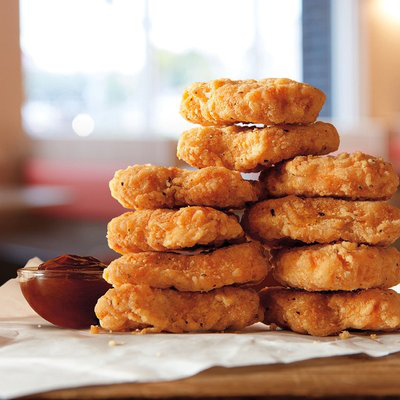

In [132]:
print(test_captions[0])
Image.open(timg_name_vector[0])

In [133]:
#Preprocess the images using InceptionV3
def load_image(timage_path):
    img = tf.io.read_file(timage_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, timage_path

In [134]:
#Caching the features extracted from InceptionV3

# Get unique images
encode_test = sorted(set(timg_name_vector))

# Feel free to change batch_size according to your system configuration
timage_dataset = tf.data.Dataset.from_tensor_slices(encode_test)
timage_dataset = timage_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(timage_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


In [135]:
tokenizer.fit_on_texts(test_captions)
test_seqs = tokenizer.texts_to_sequences(test_captions)

In [136]:
# Create the tokenized vectors
test_seqs = tokenizer.texts_to_sequences(test_captions)

In [137]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
tcap_vector = tf.keras.preprocessing.sequence.pad_sequences(test_seqs, padding='post')

In [138]:
# Calculates the max_length, which is used to store the attention weights
tmax_length = calc_max_length(test_seqs)
#print(tmax_length)

In [139]:
timg_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(timg_name_vector, tcap_vector):
    timg_to_cap_vector[img].append(cap)


timg_keys = list(timg_to_cap_vector.keys())
#random.shuffle(timg_keys)

timg_name_test_keys = timg_keys

timg_name_test = []
cap_test = []
for imgt in timg_name_test_keys:
    capt_len = len(timg_to_cap_vector[imgt])
    timg_name_test.extend([imgt] * capt_len)
    cap_test.extend(timg_to_cap_vector[imgt])

In [140]:
len(timg_name_test)

10

In [167]:
# captions on the test set


#dft['Predicted Before']=""
#dft['Predicted After']=""
#dft['Predicted Final']=""
dft['Predicted Caption']=""

for j in range(10):
    im = timg_name_test[j]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[j] if i not in [0]])
    result, attention_plot = evaluate(im)
    predicted=' '.join(result)
    
    
    #PATH="/home/shankar/Desktop/YELP/Food/DATA/"
    #for ind in dft.index:
    image_path = TPATH + 'images/'  +dft['Photo_id'][j]+ '.jpg'
    img = image.load_img(image_path,target_size=(299,299,3))
    img = image.img_to_array(img)
    img = img/255
    classes = np.array(label)
    proba = model.predict(img.reshape(1,299,299,3))
    top_3 = np.argsort(proba[0])[:-5:-1]
    label_result=classes[top_3[0]]
    
    dft['Predicted Caption'][j]=predicted
    

    print ('\nReal Caption:', real_caption)
    print ('Predicted Caption:', ' '.join(result))
    print ('Predicted Label:',label_result)
    print ('Generated Caption:', ' '.join(result)+" " +label_result)  
    

    #dft['Predicted Before'][ind]=predicted
    #print(predicted)


Real Caption: <start> nugget with tomato sauce fish <end>
Predicted Caption: philly <end>
Predicted Label: Red wine braised beef with potatoes
Generated Caption: philly <end> Red wine braised beef with potatoes

Real Caption: <start> chipotle chicken scrambled egg avocado wrap <end>
Predicted Caption: dragon chicken yes rice day white <end>
Predicted Label: Kebab
Generated Caption: dragon chicken yes rice day white <end> Kebab

Real Caption: <start> veg chicken wing and smoked tomato soup <end>
Predicted Caption: mai chicken kabobs dynamite mushroom risotto <end>
Predicted Label: Baked mackerel fillet
Generated Caption: mai chicken kabobs dynamite mushroom risotto <end> Baked mackerel fillet

Real Caption: <start> <unk> the vinegar based pork bbq dinner with baked mac and cheese steamed broccoli <unk> <end>
Predicted Caption: carnitas burger <end>
Predicted Label: Fish nuggets
Generated Caption: carnitas burger <end> Fish nuggets

Real Caption: <start> lamb shish kebab served with ric

In [168]:
dft

,Photo_id,Caption,label_predicted,Predicted Caption,Predicted Final
0,EAG5C3SFX2RGVucam81dBw,"it a tuna poke with ramen, prime ribs, mac and...",Red wine braised beef with potatoes,philly <end>,philly <end> Red wine braised beef with potatoes
1,DmS_zjsO5l18AUy0NeC3Fw,it the vinegar based pork bbq dinner with bake...,Kebab,dragon chicken yes rice day white <end>,dragon chicken yes rice day white <end> Kebab
2,ea8xZSb3o0DY2OeDu8xtNg,"lamb shish kebab served with rice , fry and ga...",Baked mackerel fillet,mai chicken kabobs dynamite mushroom risotto <...,flan chicken potato salt gelato shrimp potato ...
3,zzRPDXGXdm-kjIePvpyofQ,veg chicken wing and smoked tomato soup,Fish nuggets,carnitas burger <end>,las prime bowl egg side salad creme side order...
4,zzQga0hz996HjtyoPJlgAA,"nugget with tomato sauce, fish",Fish nuggets,one patio veal <end>,chicken year chicken <end> Fish nuggets
5,ZwtoYdGFZvazWnI4U7Y3aw,fish taco with tomato sause and lemon,Raw vegetable buffet,choice meatball basil <end>,spanish honey fried egg <end> Raw vegetable bu...
6,zwN0d64CgKHP8jrNF9ZL6Q,"roasted cauliflower with thai flavors,cauliflo...",Carrots in balsamic vinegar,roasted vegetarian wrap lemon <end>,roasted vegetarian wrap lemon <end> Carrots in...
7,ZVwsAhx8cI_Qtah60LtWVg,"confit chicken wings,chicken wing",Chicken wings,craftkitchen chicken half <end>,craftkitchen chicken half <end> Chicken wings
8,zuQxSlq4J_uHZwGkHq7Ypg,"chipotle chicken, scrambled egg & avocado wrap",Vegetable strudel,simple blackberry side plate pear rice salad b...,chicken <unk> <end> Vegetable strudel
9,ZsBZfk7hTNR-jC96pGN8Mw,"spicy chicken, curry chicken soup and with",Valencian Paella,chicken rice rolls <end>,chicken rice roll <end> Valencian Paella


In [169]:
#Save as json file

dft.to_json(r'/home/shankar/Desktop/YELP/Food/IPYNB/Rev4/files/image_cap_eval_result.json')

# Test On Uncaptioned YELP data

In [92]:
dftest = pd.read_json('/home/shankar/Desktop/YELP/Food/IPYNB/Rev4/files/uncap_test.json')
dftest = dftest.reset_index(drop=True)

In [93]:
dftest

,Photo_id
0,__BBsQh03lzjq2_zMa5N_w
1,_0W4SFZnzMZECRd23M2zTg
2,_foAkeEAn8CTveBXkwGPDQ
3,_l0-2biT_1YAAj_tmjlT0A
4,_lXUP_8Fph6cA5_Z8GMYVg
5,_nLI7woKoZ9geuex1f2UYQ
6,_ow2Bxcxlsd1ScdXz1ZB8w
7,_qbAPHZbJGLSeez1rqhEiQ
8,_R0BF5j8knzMUKx6JkiOzA
9,_S_Ph7M83IxW36UKA6qy9g


In [109]:
# Group all captions together having the same image ID.
dftest['Caption']=""
TPATH='/home/shankar/Desktop/YELP/Food/IPYNB/Rev4/'
testimage_path_to_caption = collections.defaultdict(list)
for ind in dftest.index:
    testcaption = "<start> "+ dftest['Caption'][ind]+" <end> "
    testimage_path = TPATH + 'testimage/'  +dftest['Photo_id'][ind]+ '.jpg'
    testimage_path_to_caption[testimage_path].append(testcaption)
    
testimage_paths = list(testimage_path_to_caption.keys())
random.shuffle(testimage_paths)


etest_image_paths = testimage_paths
print(len(etest_image_paths))

etest_captions = []
etimg_name_vector = []

for timage_path in etest_image_paths:
    testcaption_list = testimage_path_to_caption[timage_path]
    etest_captions.extend(testcaption_list)
    etimg_name_vector.extend([timage_path] * len(testcaption_list))
    
#Preprocess the images using InceptionV3
def load_image(timage_path):
    img = tf.io.read_file(timage_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, timage_path

#Caching the features extracted from InceptionV3

# Get unique images
eencode_test = sorted(set(etimg_name_vector))

# Feel free to change batch_size according to your system configuration
testimage_dataset = tf.data.Dataset.from_tensor_slices(eencode_test)
testimage_dataset = testimage_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(testimage_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())
        
tokenizer.fit_on_texts(etest_captions)
etest_seqs = tokenizer.texts_to_sequences(etest_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
etcap_vector = tf.keras.preprocessing.sequence.pad_sequences(etest_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
etmax_length = calc_max_length(etest_seqs)
#print(tmax_length)

etimg_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(etimg_name_vector, etcap_vector):
    etimg_to_cap_vector[img].append(cap)


etimg_keys = list(etimg_to_cap_vector.keys())
#random.shuffle(etimg_keys)

etimg_name_test_keys = etimg_keys

etimg_name_test = []
ecap_test = []
for imgt in etimg_name_test_keys:
    capt_len = len(etimg_to_cap_vector[imgt])
    etimg_name_test.extend([imgt] * capt_len)
    ecap_test.extend(etimg_to_cap_vector[imgt])
    
print(len(etimg_name_test))

100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

15
15


In [121]:
# captions on the test set


#dft['Predicted Before']=""
#dft['Predicted After']=""
dftest['Predicted Caption']=""
dftest['Predicted Label']=""
dftest['Generated Caption']=""

for j in range(15):
    im = etimg_name_test[j]
    #real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[j] if i not in [0]])
    result, attention_plot = evaluate(im)
    predicted=' '.join(result)
    dftest['Predicted Caption'][j]=predicted
    
    #PATH="/home/shankar/Desktop/YELP/Food/DATA/"
    #for ind in dft.index:
    image_path = TPATH + 'testimage/'  +dftest['Photo_id'][j]+ '.jpg'
    img = image.load_img(image_path,target_size=(299,299,3))
    img = image.img_to_array(img)
    img = img/255
    classes = np.array(label)
    proba = model.predict(img.reshape(1,299,299,3))
    top_3 = np.argsort(proba[0])[:-5:-1]
    label_result=classes[top_3[0]]
    dftest['Predicted Label'][j]=label_result
    dftest['Generated Caption'][j]=' '.join(result)+" " +label_result

    #print ('\nReal Caption:', real_caption)
    print ('\nPredicted Caption:', ' '.join(result))
    print ('Predicted Label:',label_result)
    print ('Generated Caption:', ' '.join(result)+" " +label_result)  
    

    #dft['Predicted Before'][ind]=predicted
    #print(predicted)


Predicted Caption: rice <unk> peanut <end>
Predicted Label: Mexican pork loin rolls
Generated Caption: rice <unk> peanut <end> Mexican pork loin rolls

Predicted Caption: classic restaurant shrimp scallops <end>
Predicted Label: Chickpeas Hamburger
Generated Caption: classic restaurant shrimp scallops <end> Chickpeas Hamburger

Predicted Caption: salmon custom <end>
Predicted Label: Broccoletti in oil
Generated Caption: salmon custom <end> Broccoletti in oil

Predicted Caption: salmon com <unk> grill red red poached red red poached red red poached red red poached red red poached red red poached red caprese <unk> <unk> <unk> <unk>
Predicted Label: Pasta with garlic, oil and chili peppers
Generated Caption: salmon com <unk> grill red red poached red red poached red red poached red red poached red red poached red red poached red caprese <unk> <unk> <unk> <unk> Pasta with garlic, oil and chili peppers

Predicted Caption: pancakes <end>
Predicted Label: Pasta with cherry tomatoes and arugu

In [122]:
dftest

,Photo_id,Predicted Caption,Predicted Label,Generated Caption,Caption
0,__BBsQh03lzjq2_zMa5N_w,rice <unk> peanut <end>,Mexican pork loin rolls,rice <unk> peanut <end> Mexican pork loin rolls,
1,_0W4SFZnzMZECRd23M2zTg,classic restaurant shrimp scallops <end>,Chickpeas Hamburger,classic restaurant shrimp scallops <end> Chick...,
2,_foAkeEAn8CTveBXkwGPDQ,salmon custom <end>,Broccoletti in oil,salmon custom <end> Broccoletti in oil,
3,_l0-2biT_1YAAj_tmjlT0A,salmon com <unk> grill red red poached red red...,"Pasta with garlic, oil and chili peppers",salmon com <unk> grill red red poached red red...,
4,_lXUP_8Fph6cA5_Z8GMYVg,pancakes <end>,Pasta with cherry tomatoes and arugula,pancakes <end> Pasta with cherry tomatoes and ...,
5,_nLI7woKoZ9geuex1f2UYQ,yummy <end>,Vegetable focaccia bread,yummy <end> Vegetable focaccia bread,
6,_ow2Bxcxlsd1ScdXz1ZB8w,box people <end>,Spaetzle with tomato sauce,box people <end> Spaetzle with tomato sauce,
7,_qbAPHZbJGLSeez1rqhEiQ,roasted foie fill <end>,Octopus Soup,roasted foie fill <end> Octopus Soup,
8,_R0BF5j8knzMUKx6JkiOzA,katsu freshly <end>,Steamed broccoli,katsu freshly <end> Steamed broccoli,
9,_S_Ph7M83IxW36UKA6qy9g,sear two wrap lamb takoyaki fry noodle <end>,Octopus Soup,sear two wrap lamb takoyaki fry noodle <end> O...,


In [123]:
#Save as json file
dftest.drop(['Caption'], axis=1, inplace=True)
dftest.to_json(r'/home/shankar/Desktop/YELP/Food/IPYNB/Rev4/files/test_result.json')

In [124]:
dftest

,Photo_id,Predicted Caption,Predicted Label,Generated Caption
0,__BBsQh03lzjq2_zMa5N_w,rice <unk> peanut <end>,Mexican pork loin rolls,rice <unk> peanut <end> Mexican pork loin rolls
1,_0W4SFZnzMZECRd23M2zTg,classic restaurant shrimp scallops <end>,Chickpeas Hamburger,classic restaurant shrimp scallops <end> Chick...
2,_foAkeEAn8CTveBXkwGPDQ,salmon custom <end>,Broccoletti in oil,salmon custom <end> Broccoletti in oil
3,_l0-2biT_1YAAj_tmjlT0A,salmon com <unk> grill red red poached red red...,"Pasta with garlic, oil and chili peppers",salmon com <unk> grill red red poached red red...
4,_lXUP_8Fph6cA5_Z8GMYVg,pancakes <end>,Pasta with cherry tomatoes and arugula,pancakes <end> Pasta with cherry tomatoes and ...
5,_nLI7woKoZ9geuex1f2UYQ,yummy <end>,Vegetable focaccia bread,yummy <end> Vegetable focaccia bread
6,_ow2Bxcxlsd1ScdXz1ZB8w,box people <end>,Spaetzle with tomato sauce,box people <end> Spaetzle with tomato sauce
7,_qbAPHZbJGLSeez1rqhEiQ,roasted foie fill <end>,Octopus Soup,roasted foie fill <end> Octopus Soup
8,_R0BF5j8knzMUKx6JkiOzA,katsu freshly <end>,Steamed broccoli,katsu freshly <end> Steamed broccoli
9,_S_Ph7M83IxW36UKA6qy9g,sear two wrap lamb takoyaki fry noodle <end>,Octopus Soup,sear two wrap lamb takoyaki fry noodle <end> O...
